In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import glob
import os
import itertools
from scipy.interpolate import interp1d

import matplotlib.ticker as mtick

from helper import *

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 300
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["font.size"] = 14

In [3]:
def interp(x, y, age):
    f = interp1d(x, y, fill_value="extrapolate")
    return f(age)

mode_labels = ["n1ell0m0","n2ell0m0","n3ell0m0","n4ell0m0","n5ell0m0","n6ell0m0","n7ell0m0","n8ell0m0","n9ell0m0","n10ell0m0",
         "n1ell1mm1","n2ell1mm1","n3ell1mm1","n4ell1mm1","n5ell1mm1","n6ell1mm1","n7ell1mm1","n8ell1mm1","n9ell1mm1","n10ell1mm1",
         "n1ell1m0","n2ell1m0","n3ell1m0","n4ell1m0","n5ell1m0","n6ell1m0","n7ell1m0","n8ell1m0","n9ell1m0","n10ell1m0",
         "n1ell1mp1","n2ell1mp1","n3ell1mp1","n4ell1mp1","n5ell1mp1","n6ell1mp1","n7ell1mp1","n8ell1mp1","n9ell1mp1","n10ell1mp1"]
mode_strings = ["100","200","300","400","500","600","700","800","900","1000",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1",
         "110","210","310","410","510","610","710","810","910","1010",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1"]

def get_freqs(freqs, ages, ind):
    dff = pd.DataFrame()
    dff["Dnu"] = np.repeat(np.nan, len(freqs))
    dff["eps"] = np.repeat(np.nan, len(freqs))
    for s in mode_labels:
        dff[s] = np.repeat(np.nan, len(freqs))

    freqs_df = []
    for i, row in dff.iterrows():
        df = row
        ts = freqs[i]
        ts = model_nlm(ts)
        df["age"] = ages.iloc[i]
        df["Dnu"] = model_Dnu(ts)
        df["eps"] = model_epsilon(ts)
        for j,s in enumerate(mode_strings):
            try:
                df[mode_labels[j]] = np.round(ts.query(f"nlm=='{s}'")["Re(freq)"].values[0],5)
            except:
                df[mode_labels[j]] = np.nan
        freqs_df.append(df)

    freqs_df = pd.DataFrame(freqs_df)

    l = 1
    for n in range(1, 11):
        freqs_df[f"n{n}ell{l}dfreq"] = freqs_df[f"n{n}ell{l}m0"] - freqs_df[f"n{n}ell{l}mm1"]
        freqs_df.drop(columns=[f"n{n}ell{l}mp1", f"n{n}ell{l}mm1"], inplace=True)
    columns = ['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
       'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
       'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
       'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']
    freqs_df = freqs_df[columns]
    return freqs_df
    

In [20]:
var_name = "mesh_delta_coeff"
var_samples = np.arange(0.1, 1.7, 0.2)
var_samples = np.append(var_samples, [1, 1.25])
# var_samples = [1.25]

M_sample = [1.7]
Z_sample = [0.015]
V_sample = [0]

log_dirs = glob.glob("test/m1.7_z0.015_v0_var*/LOGS")
run_times = []
var_ind = []
for i, logs_dir in enumerate(log_dirs):
    var_ind.append(int(logs_dir.split("/LOGS")[0].split("var")[-1]))
    logfn = "".join(logs_dir.split("LOGS")) + "/run.log"
    with open(logfn, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Total" in line:
                run_time = float(line.split(" ")[-2])
                run_times.append(run_time)
var_samples = [round(var_samples[i-1], 2) for i in var_ind]

combinations = itertools.product(M_sample, Z_sample, V_sample, var_samples)

print(run_times)
print(var_samples)
print(var_ind)

[
    461.2132480144501,
    652.3848984241486,
    2279.1967017650604,
    509.527375459671,
    579.9398829936981,
    1670.9988837242126,
    693.2565948963165,
    817.9263074398041,
    1031.0434262752533,
    2754.6753780841827
]

[1.5, 1.1, 0.1, 1.3, 1.0, 0.3, 0.9, 0.7, 0.5, 1.25]

[8, 6, 1, 7, 9, 2, 5, 4, 3, 10]

In [21]:
runtime_ratios = []
for i in range(len(var_samples)):
    runtime_ratios.append(round(run_times[i]/run_times[2], 2))
runtime_ratios

[0.2, 0.29, 1.0, 0.22, 0.25, 0.73, 0.3, 0.36, 0.45, 1.21]

In [12]:
combinations = itertools.product(M_sample, Z_sample, V_sample, var_samples)
data_dict = {}

k = 0
for m, z, v, var in combinations:
    print(m, z, v, var)
    key = f"M={m}_Z={z}_V={v}_var={var}"
    hist, freqs, profs, n_profs, prof_index = get_data(log_dirs[k])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    indexes = hist.index[hist.model_number.isin(models)]
    ages = hist.star_age[indexes]/1e6
    data_dict[key] = pd.DataFrame()
    data_dict[key]['age'] = hist['star_age']/1e6
    data_dict[key]['log_cntr_Rho'] = hist['log_cntr_Rho'].values
    data_dict[key]['log_cntr_T'] = hist['log_cntr_T'].values
    data_dict[key]['log_Teff'] = hist['log_Teff'].values
    data_dict[key] = pd.merge(data_dict[key], get_freqs(freqs, ages, k), on="age")
    ages = np.arange(0, data_dict[key].iloc[-1]["age"], 0.1)
    # new_df = pd.DataFrame()
    # new_df["age"] = ages
    # for column in data_dict[key].columns[1:]:
    #     new_df[column] = interp(data_dict[key]["age"], data_dict[key][column], ages)
    # data_dict[key] = new_df
    k += 1

1.7 0.015 0 1.25

Text(0, 0.5, '$\\Delta\\nu$ (d$^{-1}$)')

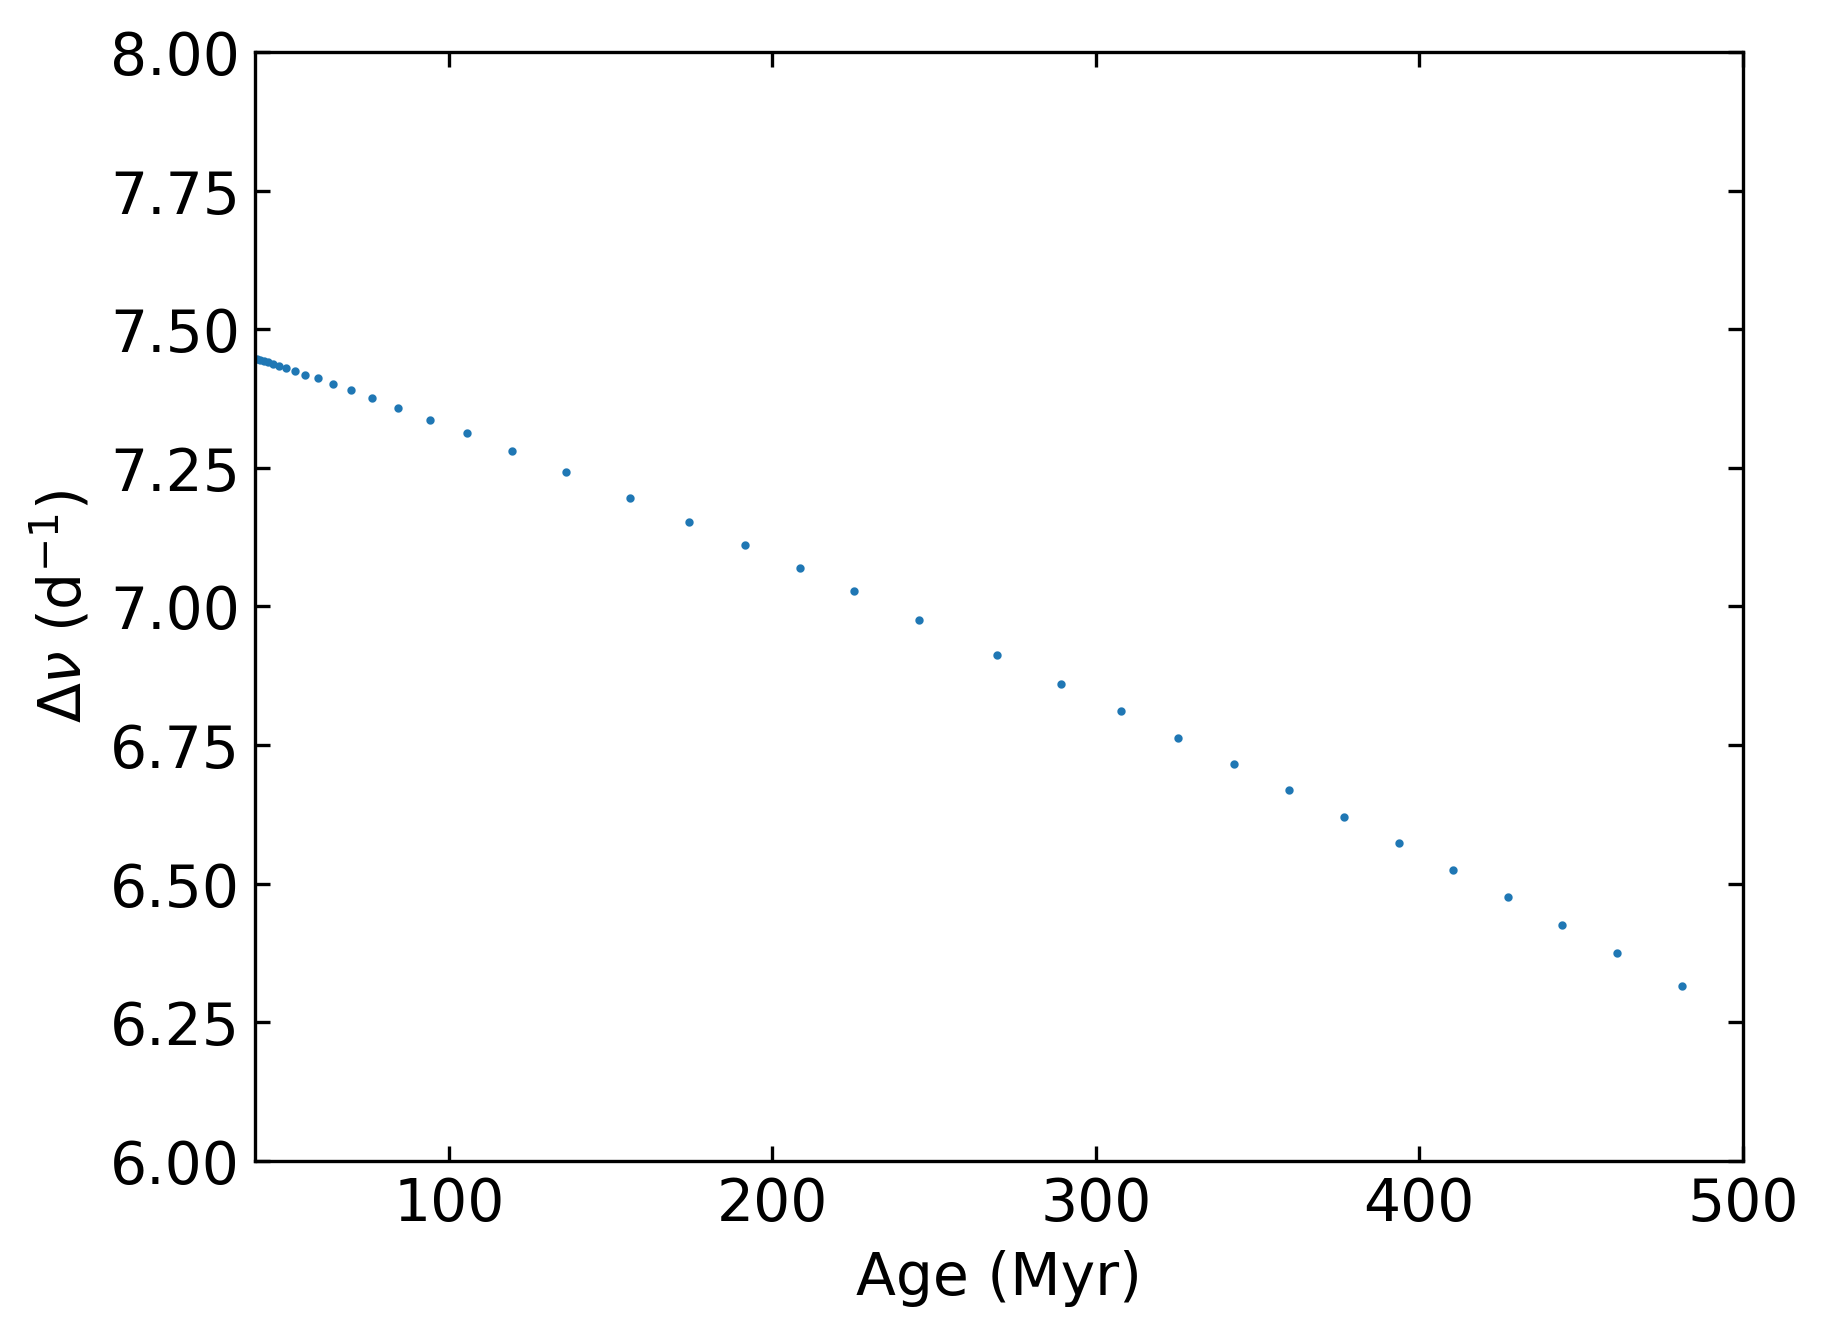

In [14]:
key = "M=1.7_Z=0.015_V=0_var=1.25"
age = data_dict[key]["age"]
Dnu = data_dict[key]["Dnu"]

plt.scatter(age, Dnu, s=1)
# plt.xlim(0, 40)
plt.xlim(40, 500)
plt.ylim(6, 8)
plt.xlabel("Age (Myr)")
plt.ylabel(r"$\Delta\nu$ (d$^{-1}$)")

In [17]:
from scipy.signal import savgol_filter  as filter
# from scipy.signal import medfilt as filter
# from scipy.signal import wiener as filter

key_ref = "M=1.7_Z=0.015_V=0_var=1.0"
mean_diffs = []
var_samples = np.round(np.append(np.arange(0.1, 1.7, 0.2), [1, 1.25]), 2)
for i in range(len(var_samples)):
    key = f"M=1.7_Z=0.015_V=0_var={var_samples[i]}"
    this_mean = []
    for i, row in data_dict[key_ref].iterrows():
        freqs_alt_0 = row[6:16].values
        freqs_alt_1 = row[17:26].values
        freqs_ref_0 = data_dict[key_ref].iloc[i][6:16].values
        freqs_ref_1 = data_dict[key_ref].iloc[i][17:26].values
        diff_0 = (freqs_ref_0 - freqs_alt_0)/freqs_ref_0
        diff_1 = (freqs_ref_1 - freqs_alt_1)/freqs_ref_1
        this_mean.append( np.mean(np.append(diff_0, diff_1)) )
    this_mean = filter(this_mean, 31, 3)
    mean_diffs.append(this_mean)

In [15]:

var_samples.pop(-1)

1.25

ValueError: Filled contours require at least 2 levels.

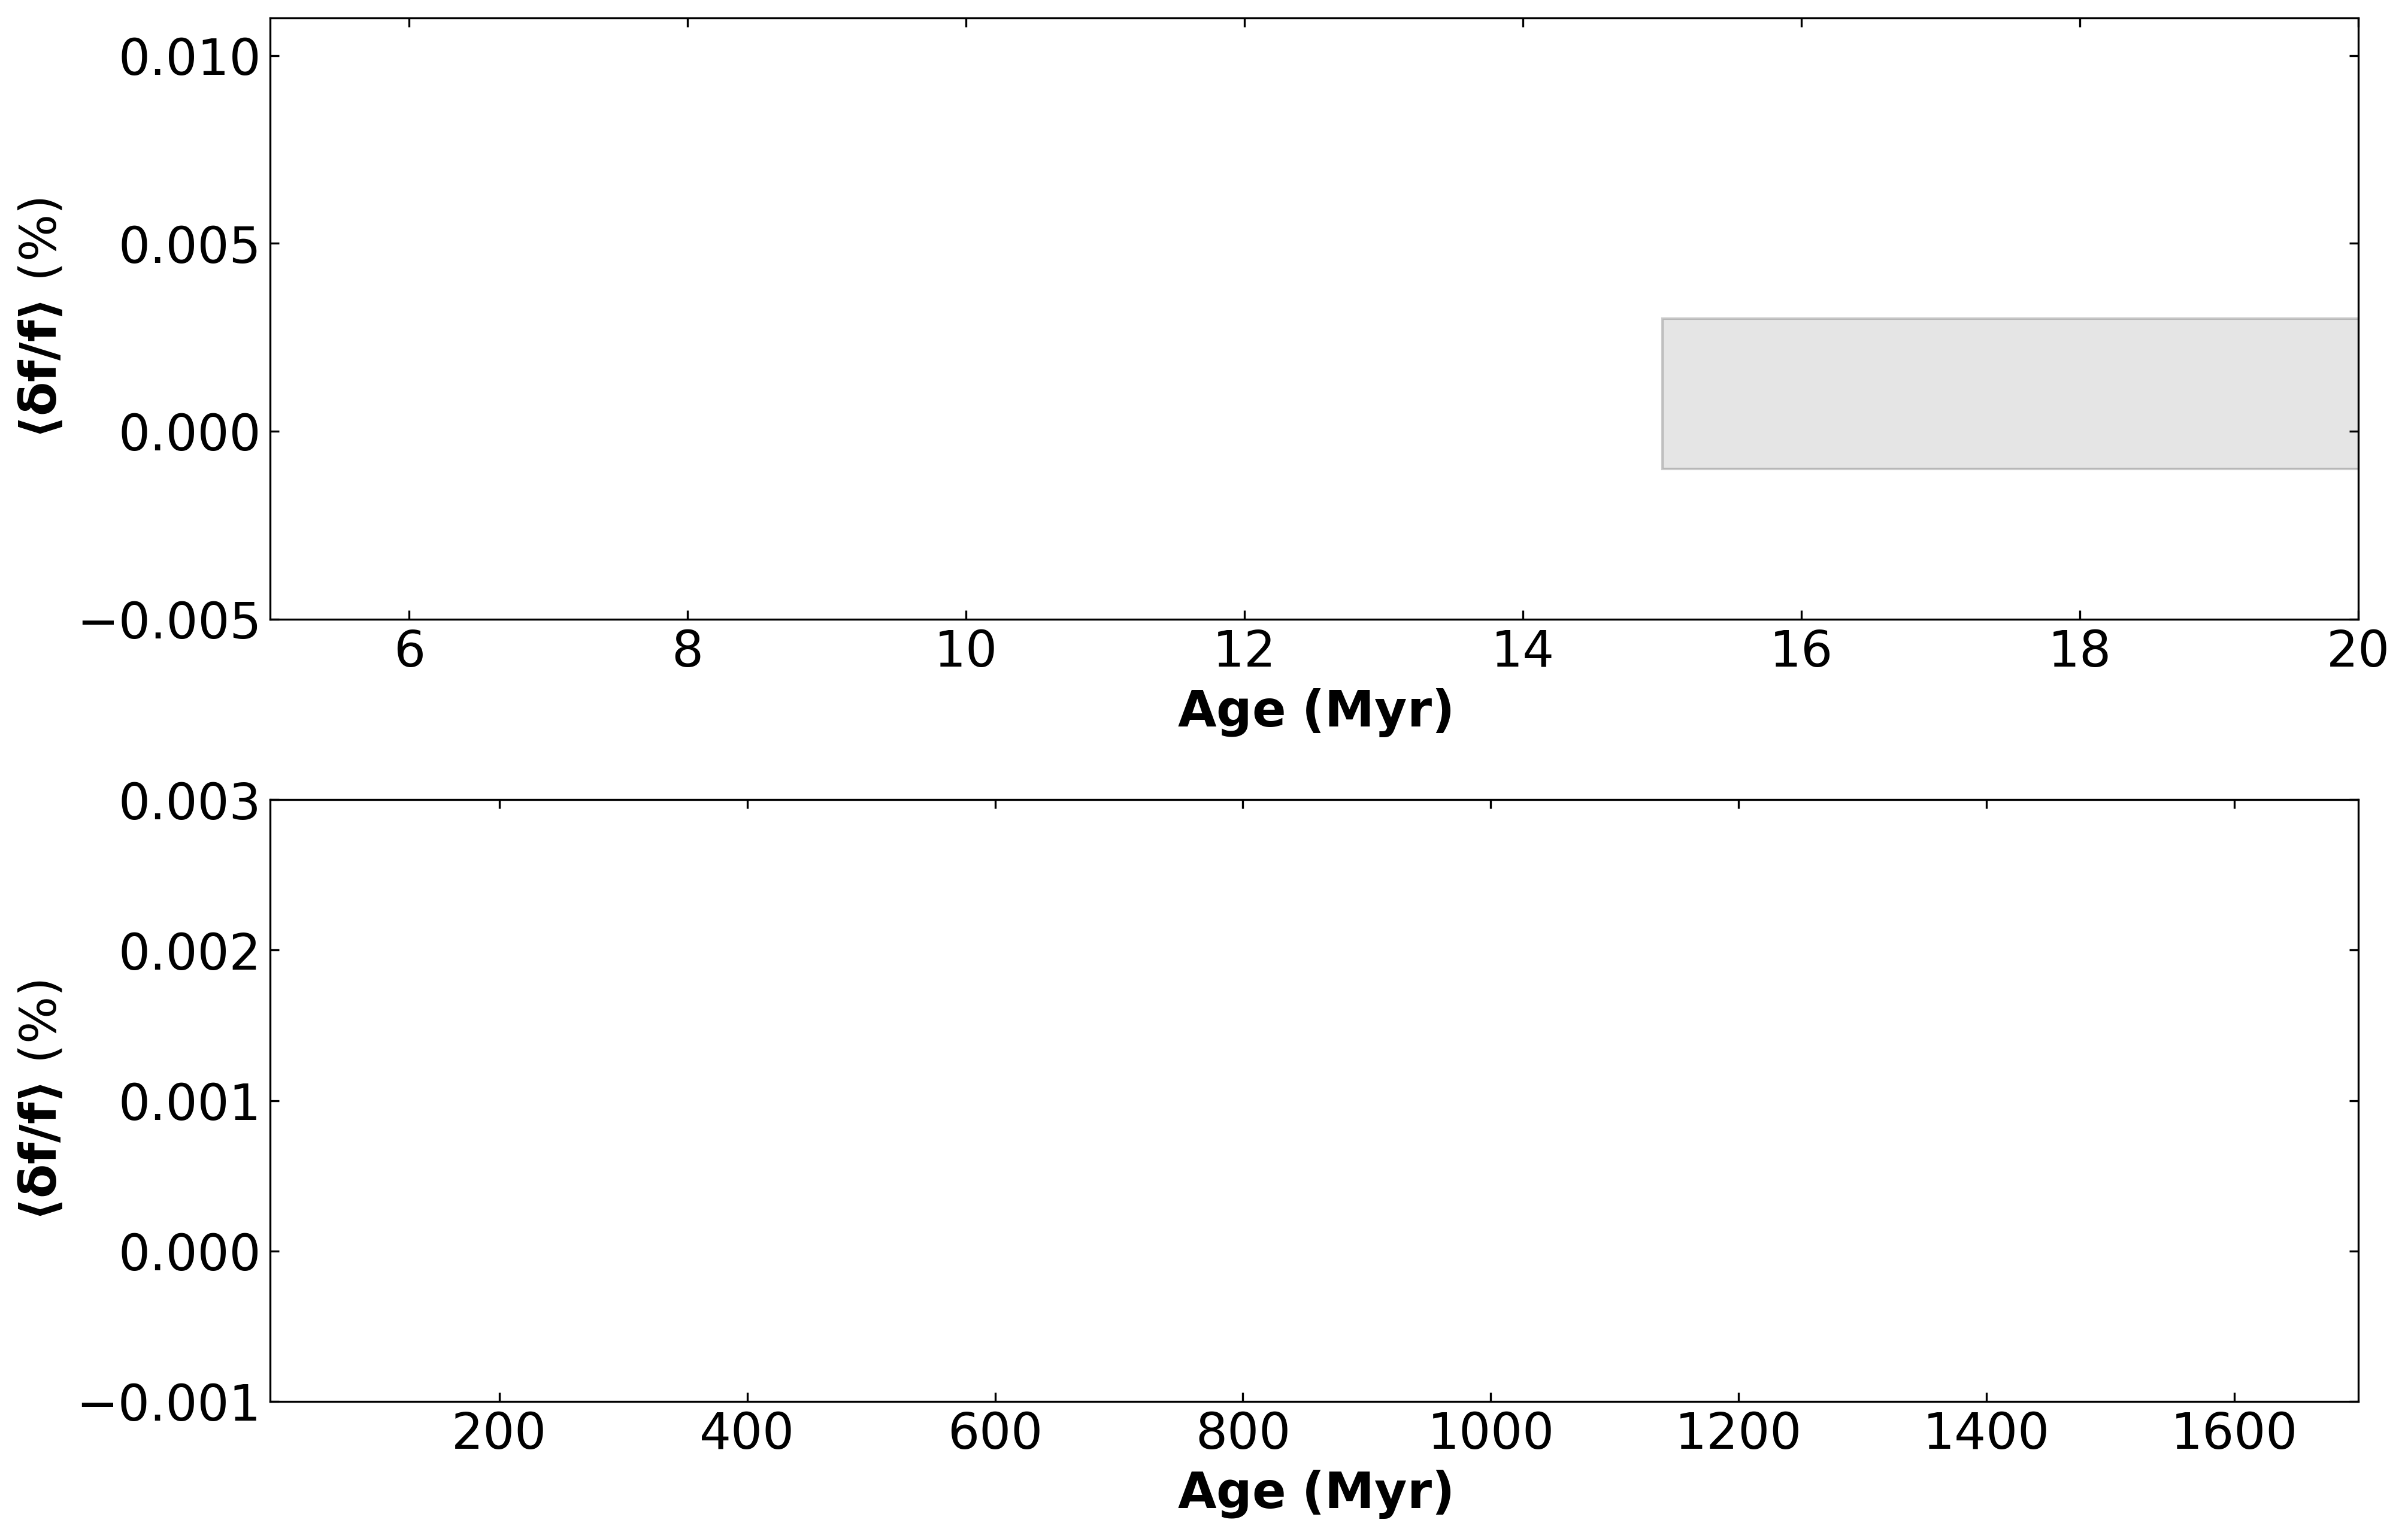

In [16]:
fig = plt.figure(figsize=(15, 10))
palette = sns.color_palette("viridis", len(var_samples))
# palette = sns.color_palette("colorblind", len(var_samples))
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

ax1 = plt.subplot(2, 1, 1)
for ind, var in enumerate(var_samples):
    key = f"M=1.7_Z=0.015_V=0_var={var}"
    age = data_dict[key]["age"].values
    # plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2, linestyle=linestyle_tuple[ind][1])
    plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2)

title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([5, 20])
plt.ylim([-0.005, 0.011])
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
rect = mpl.patches.Rectangle((15, -0.001), 20, 0.004, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
ax1.add_patch(rect)


ax2 = plt.subplot(2, 1, 2)
for ind, var in enumerate(var_samples):
    key = f"M=1.7_Z=0.015_V=0_var={var}"
    age = data_dict[key]["age"].values
    # plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2, linestyle=linestyle_tuple[ind][1])
    plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2)
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
plt.xlim([15, 1700])
plt.ylim([-0.001, 0.003])
plt.subplots_adjust(wspace=0, hspace=0.3)


Z = [[0,0],[0,0]]
levels = np.array(sorted(var_samples)+[1.7])
contour = plt.contourf(Z, levels, cmap=mpl.colors.ListedColormap(palette))
axes = [ax1, ax2]
cb = plt.colorbar(contour, ticks=levels+0.1, label=r'$\bf{mesh\_delta\_coeff}$', ax=axes)
cb.set_ticklabels([f"{level:.1f}" for level in levels])

ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))

fig.align_ylabels([ax1, ax2])
plt.show()
# plt.savefig(f'../figures/mean_diff_panels.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.plot(age, mean_diffs[0], color=palette[0], lw=2)
